<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Deep Learning</center>

# Worksheet S2: Regresión Lineal con TensorFlow

## Objetivos

El objetivo de este worksheet es familiarizarnos con TensorFlow mediante un primer ejemplo basado en regresión lineal. 

*El contenido de este worksheet está basado en el tutorial oficial de tensorflow: https://www.tensorflow.org/tutorials/estimator/linear*

## Introducción


### Regresión Lineal

Como ya sabemos, la regresión lineal es uno de los métodos más básicos de Inteligencia Artificial.

El concepto es muy sencillo, asumiendo que los datos están relacionados de forma lineal, la regresión lineal genera la línea (o plano) que se ajusta mejor a los datos existentes. Una vez encontramos esta línea (o plano) podemos utilizarla para predecir futuros valores.

A continuación podemos ver un rápido ejemplo.

(0.0, 6.0, 0.0, 20.0)

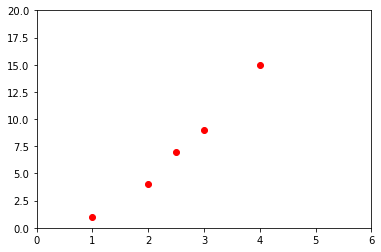

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])

Como podemos ver, hay una correspondencia lineal en los datos. En este caso, cuando el valor x aumenta, el valor de y también lo hace. En este ejemplo, como sólo tenemos 2 dimensiones, utilizaremos una de ellas como variable de entrada.

Esta sería la ecuación de la línea en 2D

$ y = mx + b $

Y así se ajustaría la línea a nuestros datos


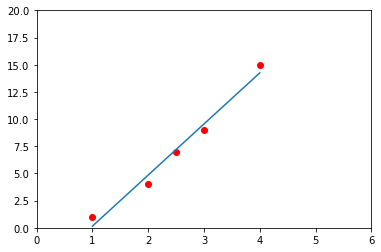

In [2]:
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

Una vez tenemos nuestra línea, podríamos utilizar su ecuación para predecir futuros valores.

### Configuración

Instalamos sklearn e importamos las librerías necesarias para nuestro ejemplo.

In [3]:
# $ pip install -q sklearn

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

### Carga de datos

Vamos a utilizar el dataset Titanic. Nuestro objetivo va a ser predecir la supervivencia de cada individuo dadas sus características: genero, edad, clase, etc.

In [4]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

### Explorando los datos

Siempre que vayamos a trabajar en un problema de ML, es importante pasar un tiempo entendiendo y curioseando los datos, a menudo, esto nos va a ahorrar mucho trabajo innecesario.


<AxesSubplot:>

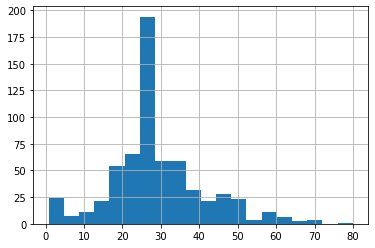

In [7]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

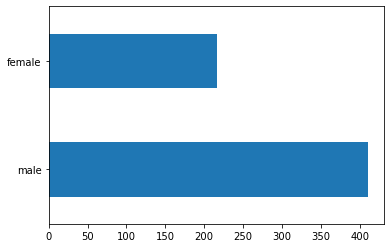

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

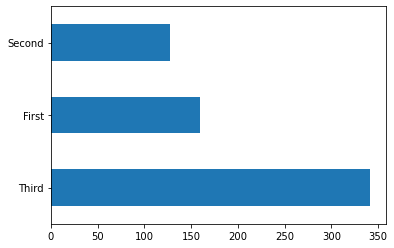

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

### Feature Columns

En este dataset hemos visto dos tipos de características: Numéricas y Categóricas.

Por regla general, nuestras redes sólo saben trabajar con características numéricas, por lo tanto, tenemos que realizar una transformación de las características que no lo son.

Por ejemplo, nuestra columna "sex" no utiliza números, utiliza las palabras "male" y "female", vamos a ver cómo podemos convertir esta y otras características, por suerte, TensorFlow tiene herramientas que a pesar de parecer complejas hacen todo el trabajo por nosotros:

In [10]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # lista de todos los valores únicos contenidos en una columna
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

Lo que estamos haciendo aquí es crear una lista de las features que se usan en nuestro dataset.

El primer bucle for está cogiendo todas las categorías que no eran numéricas, convirtiéndolas a numéricas por orden (la primera palabra única será 0, la segunda será 1, la tercera 2...), y guardándolas en feature_columns.

El segundo bucle for hace lo mismo, pero con las categorías que ya eran numéricas, por lo tanto, no debe convertirlas.

Si alguien quiere bucear un poco más en esta parte puede encontrar más información aquí:

https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list?version=stable

### Entrenamiento

Ya tenemos casi listo nuestro dataset, vamos a ver cómo entrenar nuestro modelo, empezando por cómo vamos a inyectar los datos a nuestro modelo.

Normalmente, no le damos todos los datos a nuestro modelo de una vez, si no que lo hacemos batch a batch. Un batch, es un conjunto de datos pequeño que el algoritmo evaluará antes de hacer ningún ajuste a sus parámetros. 

Por otro lado, diremos que nuestro sistema ha completado 1 época cuando haya visto todos los datos 1 vez, ya que habitualmente le mostraremos los datos varias veces para que pueda aprender más y ajustarse mejor.

Es decir, nuestro sistema verá los datos *epoch* veces en conjuntos de tamaño *batch_size*.

### Input Function

Como vamos a darle nuestros datos varias veces y en pequeños conjuntos, vamos a necesitar una función llamada *input function*. Esta función define cómo vamos a convertir nuestro dataset en batches para inyectarlos en el entrenamiento.

Los modelos TensorFlow necesitan que los datos sean objetos del tipo tf.data.Dataset. Por tanto, nuestra función va a convertir nuestros dataframes de panda en este tipo de objetos.

A continuación, veremos un ejemplo de input function.

In [11]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # función interna, esto es lo que será devuelto
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # crea un objeto tf.data.Dataset que contendrá datos y etiquetas 
    if shuffle:
      ds = ds.shuffle(1000)  # con esta línea aleatorizamos la selección de elementos
    ds = ds.batch(batch_size).repeat(num_epochs)  # divide el dataset en batches el número de veces especificado por num_epocs 
    return ds  # devuelve un batch del dataset
  return input_function  # devuelve el objeto completo para ser utilizado.

train_input_fn = make_input_fn(dftrain, y_train)  # así llamamos a la función que se nos devuelve para extraer el objeto dataset que inyectaremos en el modelo
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

### Creando el modelo

Vamos a utilizar un estimador lineal para entrenar el algoritmo de regresión.

Tan sólo tenemos que llamar al estimador y pasarle el feature_columns que habíamos hecho antes:

In [12]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/01/4d70j3nn55z71b4011q5p56r0000gn/T/tmpu6nyeh3o', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Entrenando el modelo

Para entrenar el modelo, tan sólo tenemos que pasarle las input functions que hemos creado anteriormente.

In [13]:
linear_est.train(train_input_fn)  # entrenamos el modelo
result = linear_est.evaluate(eval_input_fn)  # obtenemos las estimaciones del conjunto de evaluación

clear_output()  # limpiamos la consola
print(result['accuracy'])  # la viariable result es un diccionario con los resultados de nuestro modelo

0.7651515


Como podmeos ver, tenemos un modelo con un 74% de acierto (esto cambia con cada ejecución). No esta mal para un primer intento.

### Predicciones basadas en nuestro modelo

Vamos a ver cómo se utiliza el modelo que hemos entrenado para hacer predicciones.

Podemos utilizar el método .predict() para ver las probabilidades de supervivencia que nos da el modelo. Este método recibe 1 o varias muestras y nos devuelve la probabilidad de supervivencia de cada uno de estos individuos.

A continuación, vamos a ver en un gráfico las probabilidades de supervivencia de cada uno de los datos de test que tenemos y vamos representarlos en un histograma.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/01/4d70j3nn55z71b4011q5p56r0000gn/T/tmpu6nyeh3o/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

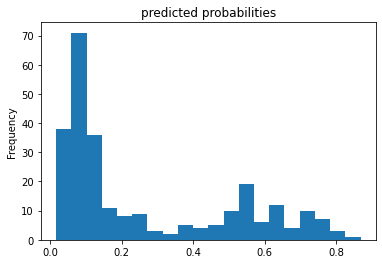

In [18]:
pred_dicts = list(linear_est.predict(eval_input_fn)) # Hace predicciones y devuelve un array con las probabilidades y los parámetros del modelo para este ejemplo

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) # Seleccionamos la probabilidad de supervivencia y lo metemos en una serie de Panda para poder representarlo fácilmente

probs.plot(kind='hist', bins=20, title='predicted probabilities') # Representamos en forma de histograma

In [17]:
list(linear_est.predict(train_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/01/4d70j3nn55z71b4011q5p56r0000gn/T/tmpu6nyeh3o/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([-1.7016864], dtype=float32),
  'logistic': array([0.15424514], dtype=float32),
  'probabilities': array([0.84575486, 0.15424514], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([1.3354094], dtype=float32),
  'logistic': array([0.791734], dtype=float32),
  'probabilities': array([0.208266  , 0.79173404], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-2.4376392], dtype=float32),
  'logistic': array([0.08034718], dtype=float32),
  'probabilities': array([0.9196529 , 0.08034719], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 